# Average density profiles with midplane mapping

At one point in time I was interested in looking at the profiles mapped to the inner and outermidplanes. However, doing this for every profile in a shot takes a pornographic amount of time, like 10-20 minutes.

So I coppied notebook "16A Average Density Profiles" here on December 14th of 2020.

#### Import libraries

In [50]:
%matplotlib notebook
from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
from __future__ import print_function
from ipfnpytools.plot import plots
from warnings import warn
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump
from ipfnpytools.current_flattop import current_flattop
from ipfnpytools.rhosep2 import rhosep2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets#### Import libraries
import pandas as pd
import reflectometry as rfl
from ipfnpytools.trz_to_rhop import trz_to_rhop, fast_trz_to_rhop
import map_equ
from ipfnpytools.trhopz_to_r import trhopz_to_r 
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### <span style="color:blue">Parameters: Data Fetching</span>

In [51]:
# Shot number
shot = 35225

# Choose edition for reflectometry (0 for most recent)
edition = 0

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# Path to dump file 
path = "../../lab_rot/phd_part23_match_0rho9/RPS_dump_1hfs07_2lfs28.34482"

# Magnetic equillibrium "EQH" or "IDE"
equillibrium = "EQH"


In [52]:
time, lfs_signal, hfs_signal, lfs_area, hfs_area = rfl.fetch(shot, path if source=='dump' else None, verbose=False)

# Unit conversion
lfs_signal*=1e-19
hfs_signal*=1e-19

# Cutoff HFS density
# idx = hfs_signal[0] < hfs_cut
# hfs_signal = hfs_signal[:, idx]
# hfs_area = hfs_area[:, idx]

# Remove NaNs
lfs_area = np.nan_to_num(lfs_area)
hfs_area = np.nan_to_num(hfs_area)

In [53]:
# Determine the plasma current flat top window --------------------

[t0, t1] = current_flattop(shot)

# Fetch reflectometry data ----------------------------------------

# time, lfs_signal, hfs_signal, lfs_area, hfs_area = rfl.fetch(shot, path if source=='dump' else None, verbose=True)
# density = lfs_signal[0,:]

# Fetch rho vs. time for the secondary separatrix -----------------

parameters = 'IDG' if equillibrium == 'IDE' else 'GQH'
# sep2_time, sep2_data = rhosep2(shot, equil=parameters) 
sep2_data = rhosep2(shot, equil=parameters, times=time) 

# Open and prepare the equilibrium shotfile -----------------------

eq = map_equ.equ_map()
eq.Open(shot, equillibrium)
#Populate the fields
eq.read_pfm()
eq.read_scalars()

# Map secondary separatrix in R[m] at antenna height --------------

zl = 0.14  # Antenna height on LFS
zh = 0.07  # Antenna height on HFS

# r_sep2_hfs, _ = trhopz_to_r(sep2_time, sep2_data, zh, shot=shot, eq_shotfile=eq)
# _, r_sep2_lfs = trhopz_to_r(sep2_time, sep2_data, zl, shot=shot, eq_shotfile=eq)



# Map primary separatrix (rho=1) in R[m] at the antenna height ---

# r_sep1_hfs, _ = trhopz_to_r(sep2_time, np.ones_like(sep2_time), zh, shot=shot, eq_shotfile=eq)
# _, r_sep1_lfs = trhopz_to_r(sep2_time, np.ones_like(sep2_time), zl, shot=shot, eq_shotfile=eq)

# Map inner and outer wall at antenna height to rho poloidal ------

inner_wall = 1.045
outer_wall = 2.22

# inner_wall_rho = fast_trz_to_rhop(np.atleast_2d(time).T * np.ones(lfs_area.shape[1]), np.ones_like(lfs_area)*inner_wall, np.ones_like(lfs_area)*zh, shot, equillibrium=equillibrium, eq_shotfile=eq)
# outer_wall_rho = fast_trz_to_rhop(np.atleast_2d(time).T * np.ones(lfs_area.shape[1]), np.ones_like(lfs_area)*outer_wall, np.ones_like(lfs_area)*zl, shot, equillibrium=equillibrium, eq_shotfile=eq)

inner_wall_rho = fast_trz_to_rhop(time, np.ones_like(time)*inner_wall, np.ones_like(time)*zh, eq_shotfile=eq)
outer_wall_rho = fast_trz_to_rhop(time, np.ones_like(time)*outer_wall, np.ones_like(time)*zl, eq_shotfile=eq)

# Map reflectomety density profiles to rho poloidal ---------------

rhol = fast_trz_to_rhop(np.atleast_2d(time).T * np.ones(lfs_area.shape[1]), lfs_area, np.ones_like(lfs_area)*zl, eq_shotfile=eq)
rhoh = fast_trz_to_rhop(np.atleast_2d(time).T * np.ones(lfs_area.shape[1]), hfs_area, np.ones_like(hfs_area)*zh, eq_shotfile=eq)

# rhol = np.nan_to_num(rhol)
# rhoh = np.nan_to_num(rhoh)

In [54]:
%%time

# Map reflectomety density profiles to R at the outer and inner midplanes -----------
# This is a very complicated process -------------------------------
lfs_nan_mask = np.isnan(rhol)
hfs_nan_mask = np.isnan(rhoh)

input_timel = (np.atleast_2d(time).T * np.ones(rhol.shape[1]))[~lfs_nan_mask]
input_rhol = rhol[~lfs_nan_mask]
input_timeh = (np.atleast_2d(time).T * np.ones(rhoh.shape[1]))[~hfs_nan_mask]
input_rhoh = rhoh[~hfs_nan_mask]

# input_timel = (np.atleast_2d(time).T * np.ones(rhol.shape[1])).flatten()
# input_rhol = rhol.flatten()
# input_timeh = (np.atleast_2d(time).T * np.ones(rhoh.shape[1])).flatten()
# input_rhoh = rhoh.flatten()

rhol_inner = np.full_like(rhol, np.nan)
rhol_outer = np.full_like(rhol, np.nan)

rhoh_inner = np.full_like(rhoh, np.nan)
rhoh_outer = np.full_like(rhoh, np.nan)

r_lfs_inner, r_lfs_outer = trhopz_to_r(input_timel, input_rhol, np.zeros_like(input_timel), eq_shotfile=eq)
r_hfs_inner, r_hfs_outer = trhopz_to_r(input_timeh, input_rhoh, np.zeros_like(input_timeh), eq_shotfile=eq)

rhol_inner[~lfs_nan_mask] = r_lfs_inner
rhol_outer[~lfs_nan_mask] = r_lfs_outer

rhoh_inner[~hfs_nan_mask] = r_hfs_inner
rhoh_outer[~hfs_nan_mask] = r_hfs_outer

Optimus prime
Optimus prime
CPU times: user 31min 14s, sys: 2min 9s, total: 33min 23s
Wall time: 16min 55s


### <span style="color:blue">Parameters: Post Processing</span>

In [55]:

# Size of window to average profiles [ms]
time_window = 100


In [56]:
N = int(time_window*1e-3 / (time[1] - time[0]))
print("Averaging %d profiles on a %.3lf ms window." % (N, time_window))

lfs_average = pd.DataFrame(lfs_area).rolling(window=N).mean().values
hfs_average = pd.DataFrame(hfs_area).rolling(window=N).mean().values

lfs_std = pd.DataFrame(lfs_area).rolling(window=N).std().values
hfs_std = pd.DataFrame(hfs_area).rolling(window=N).std().values

Averaging 571 profiles on a 100.000 ms window.


In [57]:
rhol_average = pd.DataFrame(np.nan_to_num(rhol)).rolling(window=N, center=True).mean().values
rhoh_average = pd.DataFrame(np.nan_to_num(rhoh)).rolling(window=N, center=True).mean().values

rhol_std = pd.DataFrame(np.nan_to_num(rhol)).rolling(window=N, center=True).std().values
rhoh_std = pd.DataFrame(np.nan_to_num(rhoh)).rolling(window=N, center=True).std().values

In [58]:
r_lfs_inner_average = pd.DataFrame(np.nan_to_num(rhol_inner)).rolling(window=N, center=True).mean().values
r_hfs_inner_average = pd.DataFrame(np.nan_to_num(rhoh_inner)).rolling(window=N, center=True).mean().values

r_lfs_inner_std = pd.DataFrame(np.nan_to_num(rhol_inner)).rolling(window=N, center=True).std().values
r_hfs_inner_std = pd.DataFrame(np.nan_to_num(rhoh_inner)).rolling(window=N, center=True).std().values

In [59]:
r_lfs_outer_average = pd.DataFrame(np.nan_to_num(rhol_outer)).rolling(window=N, center=True).mean().values
r_hfs_outer_average = pd.DataFrame(np.nan_to_num(rhoh_outer)).rolling(window=N, center=True).mean().values

r_lfs_outer_std = pd.DataFrame(np.nan_to_num(rhol_outer)).rolling(window=N, center=True).std().values
r_hfs_outer_std = pd.DataFrame(np.nan_to_num(rhoh_outer)).rolling(window=N, center=True).std().values

### <span style="color:blue">Parameters: Suport Signal</span>

In [60]:
# Signal to overlay the density profiles
support_signal = ('NIS', 'PNI')
# support_signal = ('FPG', 'dRXP')
# support_signal = ('DCN', 'H-1')
# support_signal = ('GQH', 'Rin')

# Choose edition for the supporting signal (0 for most recent)
support_signal_edition = 0

<IPython.core.display.Javascript object>


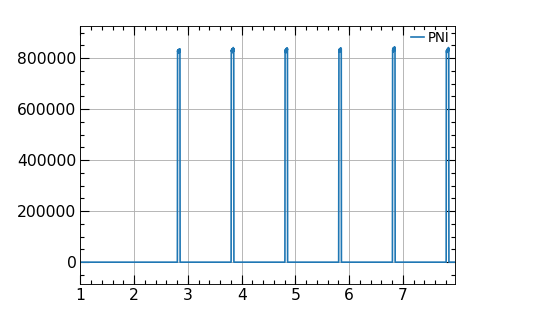

In [61]:
signal = getsig(shot, support_signal[0], support_signal[1], edition=support_signal_edition)
plots(signal.time, signal.data, labels=signal.name)
plt.xlim((t0, t1))
rfl.autoscale(plt.gca())

### <span style="color:blue">Parameters: Data Visualization</span>

In [88]:
# Number of density profiles to show in the plots
number_of_profiles = 2

# Show error bars corresponding to the standard deviation of the average profile
show_std = True

# Show HFS and LFS rho profiles in the same window
show_same = True

# Show wall (requirement: show_wall & show_2sep = False)
show_wall = True

# Show secondary separatrix
show_2sep = False

# HFS cutoff density (1e19 m^-3)
hfs_cut = 4

### Plot density vs. R \[m\]

<IPython.core.display.Javascript object>


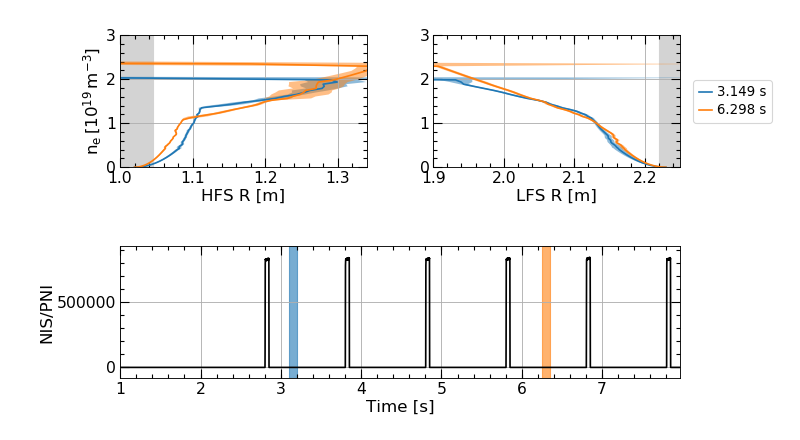

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTMuMTQ5MjA3ODMwNDI5MDc3LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTEwLjAsIHJlYWRvdXRfZm9ybWF0PXXigKY=


In [89]:
fig1, ax1, ax2, ax3 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time, y2=hfs_average, y3=lfs_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=hfs_std if show_std else None, 
    ey3=lfs_std if show_std else None,
    lx1="Time [s]", ly1=support_signal[0] + '/' + support_signal[1],
    ly2="HFS R [m]", lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3="LFS R [m]", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=None, m3=None, 
    stripe_pts=N, show_same=False, 
    paint_rho=False, paint_wall=True,
    sharex=False, sharey=True,
)

## <span style="color:blue">Parameters</span>
Change the above figure manualy with your cursor, or by running the following cell

In [90]:
fig1.set_size_inches(10, 5.5)  # Figure size in inches (widht, height)

ax1.set_xlim((t0, t1))  # Bottom plot x-range
# ax1.set_ylim(-0.05, 0.01)  # Bottom plot y-range
rfl.autoscale(ax1)

ax2.set_xlim(1.00, 1.34)  # Top-left## <span style="color:blue">Parameters</span>
ax2.set_ylim(0, 3.)  # Top-left plot y-range

ax3.set_xlim(1.9, 2.25) # Top-right plot x-range
ax3.set_ylim(0, 3.)  # Top-right plot y-range

(0, 3.0)

### Plot density vs. Outer midplane R \[m\]

<IPython.core.display.Javascript object>


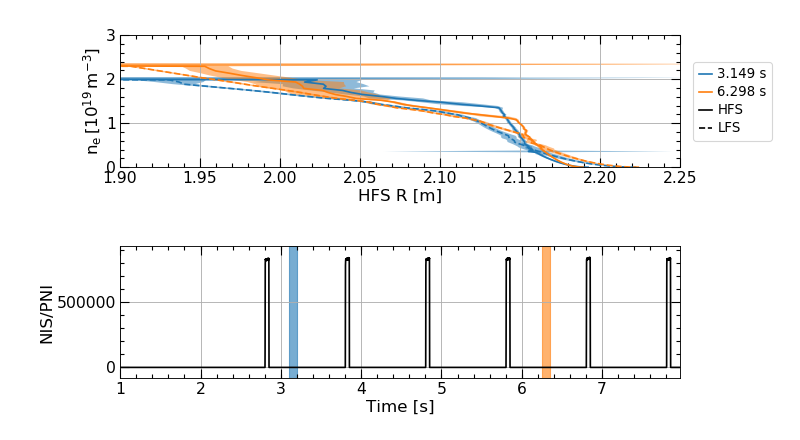

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTMuMTQ5MjA3ODMwNDI5MDc3LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTEwLjAsIHJlYWRvdXRfZm9ybWF0PXXigKY=


In [91]:
fig11, ax11, ax22, ax33 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time, y2=r_hfs_outer_average, y3=r_lfs_outer_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=r_hfs_outer_std if show_std else None, 
    ey3=r_lfs_outer_std if show_std else None,
    lx1="Time [s]", ly1=support_signal[0] + '/' + support_signal[1],
    ly2="HFS R [m]", lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3="LFS R [m]", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=None, m3=None, 
    stripe_pts=N, show_same=show_same, 
    paint_rho=False, paint_wall=False,
    sharex=False, sharey=True,
)

## <span style="color:blue">Parameters</span>
Change the above figure manualy with your cursor, or by running the following cell

In [92]:
fig11.set_size_inches(10, 5.5)  # Figure size in inches (widht, height)

ax11.set_xlim((t0, t1))  # Bottom plot x-range
# ax1.set_ylim(-0.05, 0.01)  # Bottom plot y-range
rfl.autoscale(ax11)

# ax22.set_xlim(1.00, 1.34)  # Top-left## <span style="color:blue">Parameters</span>
# ax22.set_ylim(0, 3.)  # Top-left plot y-range

ax33.set_xlim(1.9, 2.25) # Top-right plot x-range
ax33.set_ylim(0, 3.)  # Top-right plot y-range

(0, 3.0)

### Plot density vs. Inner midplane R \[m\]

<IPython.core.display.Javascript object>


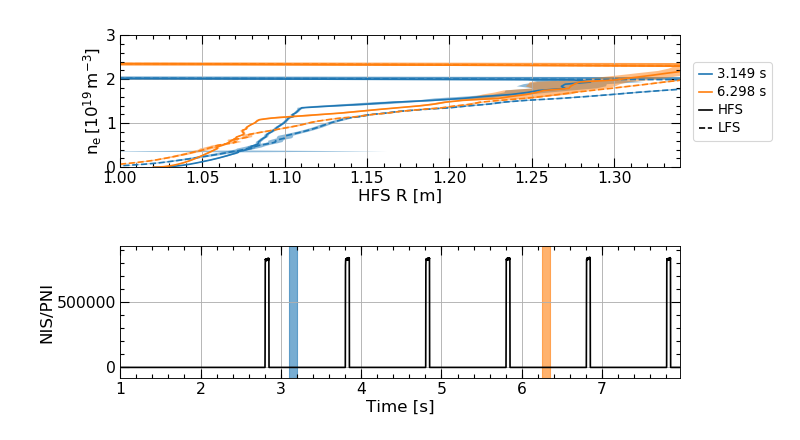

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTMuMTQ5MjA3ODMwNDI5MDc3LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTEwLjAsIHJlYWRvdXRfZm9ybWF0PXXigKY=


In [93]:
fig111, ax111, ax222, ax333 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time, y2=r_hfs_inner_average, y3=r_lfs_inner_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=r_hfs_outer_std if show_std else None, 
    ey3=r_lfs_outer_std if show_std else None,
    lx1="Time [s]", ly1=support_signal[0] + '/' + support_signal[1],
    ly2="HFS R [m]", lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3="LFS R [m]", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=None, m3=None, 
    stripe_pts=N, show_same=show_same, 
    paint_rho=False, paint_wall=False,
    sharex=False, sharey=True,
)

## <span style="color:blue">Parameters</span>
Change the above figure manualy with your cursor, or by running the following cell

In [94]:
fig111.set_size_inches(10, 5.5)  # Figure size in inches (widht, height)

ax111.set_xlim((t0, t1))  # Bottom plot x-range
# ax1.set_ylim(-0.05, 0.01)  # Bottom plot y-range
rfl.autoscale(ax111)

ax222.set_xlim(1.00, 1.34)  # Top-left## <span style="color:blue">Parameters</span>
ax222.set_ylim(0, 3.)  # Top-left plot y-range

# ax333.set_xlim(1.9, 2.25) # Top-right plot x-range
# ax333.set_ylim(0, 3.)  # Top-right plot y-range

(0, 3.0)

### Plot density vs. $\rho$

<IPython.core.display.Javascript object>


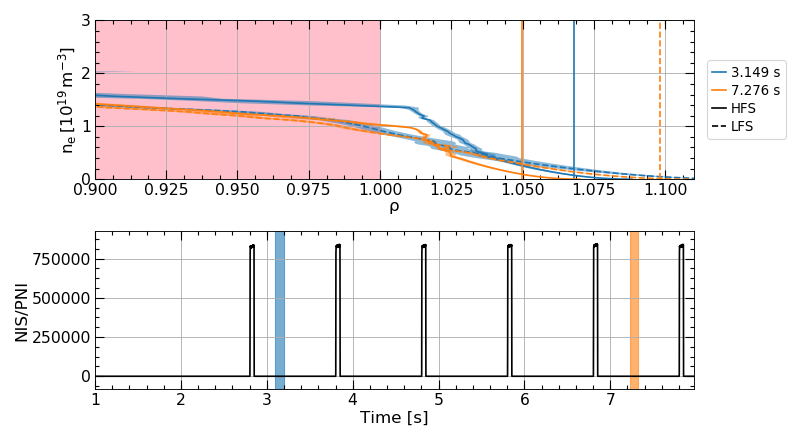

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTMuMTQ5MjA3ODMwNDI5MDc3LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTEwLjAsIHJlYWRvdXRfZm9ybWF0PXXigKY=


In [95]:
if show_2sep:
    inner_marker = sep2_data
    outer_marker = sep2_data
elif show_wall:
    inner_marker = inner_wall_rho
    outer_marker = outer_wall_rho

fig2, ax4, ax5, ax6 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time, y2=rhoh_average, y3=rhol_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=rhoh_std if show_std else None, 
    ey3=rhol_std if show_std else None,
    lx1="Time [s]", ly1=support_signal[0] + '/' + support_signal[1],
    ly2=r"$\rho$" if show_same else r"HFS $\rho$ poloidal",### Plot density vs. $\rho$ 
    lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3=r"LFS $\rho$ poloidal", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=inner_marker if (show_wall or show_2sep) else None, 
    m3=outer_marker if (show_wall or show_2sep) else None, 
    stripe_pts=N, show_same=show_same, 
    paint_rho=True, paint_wall=False,
    sharex=False, sharey=True,
)


# *** PARAMETERS ***
# Plotting options. `None` means automatic

fig2.set_size_inches(10, 7)

ax4.set_xlim(None, None)  # Bottom plot x-range
ax4.set_ylim(None, None)  # Bottom plot y-range

ax5.set_xlim(0.9, 1.2)  # Top-left plot x-range
ax5.set_ylim(0, 3.3)  # Top-left plot y-range

ax6.set_xlim(0.9, 1.2) # Top-right plot x-range
ax6.set_ylim(0, 3.3)  # Top-right plot y-range

plt.tight_layout()

## <span style="color:blue">Parameters</span>
Change the figure manualy with your cursor, or by running the following cell

In [101]:
fig2.set_size_inches(10, 5.5)  # Figure size in inches (width, height)
# fig2.set_size_inches(7, 7)  # Figure size in inches (width, height)

ax4.set_xlim(t0, t1)  # Bottom plot x-range
# ax4.set_xlim((1.1, 1.4))  # Bottom plot x-range
rfl.autoscale(ax4)

# ax5.set_xticklabels([])
# ax5.set_xlabel("")

ax5.set_xlim(0.9, 1.11)  # Top-left plot x-range
ax5.set_ylim(0, 3)  # Top-left plot y-range

ax6.set_xlim(0.9, 1.11) # Top-right plot x-range
ax6.set_ylim(0, 3)  # Top-right plot y-range

plt.tight_layout()

In [97]:
# kids = ax5.get_children()
# kids[1].set_facecolor('C0')
# kids[2].set_facecolor('C1')
# kids[3].set_color('C0')
# kids[4].set_color('C1')
# kids[4].set_linestyle('-')
# kids[5].set_color('C0')
# kids[6].set_color('C1')
# kids[6].set_linestyle('-')


In [98]:
# text1 = ax5.annotate("inner limiter", (1.04, 1.6), rotation='vertical')
# text2 = ax5.annotate("outer limiter", (1.09, 1.6), rotation='vertical')

In [99]:
# file_path = '../../augped/output/augped_fits_34482_2.900-3.100s.dat'

# with open(file_path, "r") as f:
#     data = pd.read_csv(f, skiprows=9, sep=r' *')
    
# ax5.plot(data.rho.to_numpy(), data.fit.to_numpy()*1e-19, color='C2', lw=3)

### Save the figure to your working directory

In [100]:
# fig_name = "/afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/%d/%d_average_profile_rho" % (shot, shot)
# save_figure(fig2, fig_name)